In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from shapely.geometry import Point

from mpl_toolkits.axes_grid1 import make_axes_locatable
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from sklearn.neighbors import DistanceMetric
from math import radians

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


from sklearn import svm
from sklearn import metrics


from sklearn.datasets import make_moons, make_blobs
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, classification_report, make_scorer, recall_score, f1_score
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier

In [3]:
df = pd.read_csv('df.csv', sep=';') 
df.head()

,Id,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Pressure3pm,Cloud9am,Cloud3pm,RainToday,RainTomorrow,month,year,season,regions,referent
0,0,01/12/2008,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,...,1007.1,8.0,NaN,No,No,12,2008,summer,Victoria,WaggaWagga
1,1,02/12/2008,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,...,1007.8,NaN,NaN,No,No,12,2008,summer,Victoria,WaggaWagga
2,2,03/12/2008,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,...,1008.7,NaN,2.0,No,No,12,2008,summer,Victoria,WaggaWagga
3,3,04/12/2008,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,...,1012.8,NaN,NaN,No,No,12,2008,summer,Victoria,WaggaWagga
4,4,05/12/2008,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,...,1006.0,7.0,8.0,No,No,12,2008,summer,Victoria,WaggaWagga


In [4]:
aus_town_gps = pd.read_csv("aus_town_gps.csv",sep=",")
climatsaus = pd.read_csv("climatsAUS_v2.csv",sep=";")

In [5]:
df.describe(include='object')

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow,season,regions,referent
count,142193,142193,140552,140410,141823,142137,142193,142193,142193,142193
unique,3436,49,16,16,16,2,2,4,9,32
top,01/12/2013,Canberra,W,N,SE,No,No,autumn,New_South_Wales,Melbourne
freq,49,3418,10219,12372,10996,110317,110316,37397,47712,11959


In [6]:
#Attribution de la classe de climat (classification de Köppen) pour chaque ville
climatsaus.head()

,Location,Climat_Koppen
0,Uluru,BSh
1,Woomera,Bwh
2,Adelaide,Csa
3,Albany,Csb
4,MountGambier,Csb


In [7]:
# Pour simplifier, on regroupe les climats en 4 catégories : chaud_humide, tempéré_froid, sec et méditerranéen. On pourra ainsi faire des visualisations plus facilement.

climats_type = {'Am':'chaud_humide',
                'Aw':'chaud_humide',
                'Cfa':'chaud_humide',
                'Cfb':'tempéré_froid', 
                'Cfc':'tempéré_froid', 
                'BSh':'sec',
                'BSk':'sec',
                'Bsk':'sec', 
                'Bwh':'sec',
                'Csa':'méditerranéen',
                'Csb':'méditerranéen'              
               }

climatsaus['Clim_type']=climatsaus['Climat_Koppen'].map(climats_type)

In [8]:
#Fusion des dataframes

df = pd.merge(df, aus_town_gps, how='left', left_on="Location",right_on="Location")
df = pd.merge(df, climatsaus, how='left', left_on="Location",right_on="Location")
df.head(10)

,Id,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,RainTomorrow,month,year,season,regions,referent,Latitude,Longitude,Climat_Koppen,Clim_type
0,0,01/12/2008,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,...,No,12,2008,summer,Victoria,WaggaWagga,-36.065766,146.910315,Cfa,chaud_humide
1,1,02/12/2008,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,...,No,12,2008,summer,Victoria,WaggaWagga,-36.065766,146.910315,Cfa,chaud_humide
2,2,03/12/2008,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,...,No,12,2008,summer,Victoria,WaggaWagga,-36.065766,146.910315,Cfa,chaud_humide
3,3,04/12/2008,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,...,No,12,2008,summer,Victoria,WaggaWagga,-36.065766,146.910315,Cfa,chaud_humide
4,4,05/12/2008,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,...,No,12,2008,summer,Victoria,WaggaWagga,-36.065766,146.910315,Cfa,chaud_humide
5,5,06/12/2008,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,...,No,12,2008,summer,Victoria,WaggaWagga,-36.065766,146.910315,Cfa,chaud_humide
6,6,07/12/2008,Albury,14.3,25.0,0.0,NaN,NaN,W,50.0,...,No,12,2008,summer,Victoria,WaggaWagga,-36.065766,146.910315,Cfa,chaud_humide
7,7,08/12/2008,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,...,No,12,2008,summer,Victoria,WaggaWagga,-36.065766,146.910315,Cfa,chaud_humide
8,8,09/12/2008,Albury,9.7,31.9,0.0,NaN,NaN,NNW,80.0,...,Yes,12,2008,summer,Victoria,WaggaWagga,-36.065766,146.910315,Cfa,chaud_humide
9,9,10/12/2008,Albury,13.1,30.1,1.4,NaN,NaN,W,28.0,...,No,12,2008,summer,Victoria,WaggaWagga,-36.065766,146.910315,Cfa,chaud_humide


In [9]:
#création de quelques variables de date et conversion de raintoday et raintomorrow en numériques
df['RainToday_Num'] = (df['RainToday'] ==  'Yes')*1
df['RainTomorrow_Num'] = (df['RainTomorrow'] ==  'Yes')*1
df['Date'] = pd.to_datetime(df['Date'])
df['Mois'] = df['Date'].dt.month
df['Trimestre'] = df['Date'].dt.quarter
df['Annee'] = df['Date'].dt.year

In [10]:
#création d'un dictionnaire associant la direction du vent à l'angle correspondant (en degrés) sur le cercle trigonométrique (ie. E=0° et rotation dans le sens direct)
angles = {'E':0, 
          'ENE':22.5, 
          'NE':45, 
          'NNE':67.5, 
          'N':90, 
          'NNW':112.5, 
          'NW':135, 
          'WNW':157.5, 
          'W':180, 
          'WSW':202.5, 
          'SW':225, 
          'SSW':247.5, 
          'S':270, 
          'SSE':292.5, 
          'SE':315, 
          'ESE':337.5}

In [11]:
#ajout des variables indiquant l'angle du vent au DF
df['WindGust_Ang']=df['WindGustDir'].map(angles)
df['Wind9am_Ang'] = df['WindDir9am'].map(angles)
df['Wind3pm_Ang'] = df['WindDir3pm'].map(angles)

#ajout de variables correspondant au cosinos de l'angle (abscisse des coordonnées trigo). Un cosinus négatif correspond à un vent d'ouest, un cosinus positif à un vent d'est.
df['WindGust_cos'] = np.cos(np.radians(df['WindGust_Ang']))
df['Wind9am_cos'] = np.cos(np.radians(df['Wind9am_Ang']))
df['Wind3pm_cos'] = np.cos(np.radians(df['Wind3pm_Ang']))

#ajout de variables correspondant au sinus de l'angle (ordonnée des coordonnées trigo). Un sinus négatif correspond à un vent de sud, un sinus positif à un vent de nord.
df['WindGust_sin'] = np.sin(np.radians(df['WindGust_Ang']))
df['Wind9am_sin'] = np.sin(np.radians(df['Wind9am_Ang']))
df['Wind3pm_sin'] = np.sin(np.radians(df['Wind3pm_Ang']))

In [12]:
df["LogRainfall"] = np.log(df["Rainfall"])
df["LogEvaporation"] = np.log(df["Evaporation"])

df= df.sort_values(["Location","Date"])
df["Rain_J-1"] = df["RainToday_Num"].shift(1)
df["Rain_J-2"] = df["RainToday_Num"].shift(2)
df["Rain_J+2"] = df["RainToday_Num"].shift(-2)
df["Rain_J+3"] = df["RainToday_Num"].shift(-3)

In [14]:
#On supprime toutes les observations avec des NA pour le moment
df1 = df.dropna()

labelencoder = LabelEncoder()
df1['Clim_type1'] = labelencoder.fit_transform(df1['Clim_type'])

#Pour les algos de detection d'anomalie, la convention est de mettre -1 pour la modalité à détecter*/

df1["Class"] = df1["RainTomorrow_Num"]
df1['Class'].replace({1: -1}, inplace=True)
df1['Class'].replace({0: 1}, inplace=True)


features = ["RainToday_Num","Rain_J-1","Rain_J-2","MinTemp","MaxTemp","Mois","Sunshine","Evaporation",
            "Humidity3pm","Humidity9am","Pressure3pm","Cloud3pm","Cloud9am", 
            "Wind9am_cos","Wind3pm_cos","WindGust_cos","Wind9am_sin","Wind3pm_sin","WindGust_sin", "Clim_type1"]

target = df1["RainTomorrow_Num"]
target_ano = df1["Class"]
data = df1[features]

In [17]:
X_train, X_test, y_train, y_test, y_train_ano, y_test_ano = train_test_split(data, target, target_ano, test_size=0.2, random_state=123)

In [18]:
#Grille de recherche pour avoir les meilleurs hyperparametres pour le criterion et max_depth.

param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(3, 15),'min_samples_split':[300],'min_samples_leaf':[100]}
nfolds = 3

resc_dt = make_scorer(f1_score,pos_label=1)

# decision tree model
dtree_model=DecisionTreeClassifier()
#use gridsearch to test all values
dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=nfolds, scoring=resc_dt)
#fit model to data
dtree_gscv.fit(X_train, y_train)

dtree_gscv.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 100,
 'min_samples_split': 300}

In [19]:
#Création de l'arbre avec les meilleurs hyperparametres calcules ci dessus

dt_clf = DecisionTreeClassifier(criterion='gini', max_depth=7,random_state=123,)
dt_clf.fit(X_train , y_train)

DecisionTreeClassifier(max_depth=7, random_state=123)

In [20]:
y_pred = dt_clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

## Méthode 2 : à l'aide de pandas
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm

Accuracy: 0.8394409259663682


Classe prédite,0,1
Classe réelle,,
0,16916,864
1,2812,2303


In [21]:
feats = {}
for feature, importance in zip(data.columns, dt_clf.feature_importances_):
    feats[feature] = importance 
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances.sort_values(by='Importance', ascending=False).head(8)

,Importance
Humidity3pm,0.648859
Sunshine,0.136869
Pressure3pm,0.115033
RainToday_Num,0.027869
Clim_type1,0.015336
Cloud3pm,0.013481
Wind9am_sin,0.012299
Wind3pm_sin,0.011296


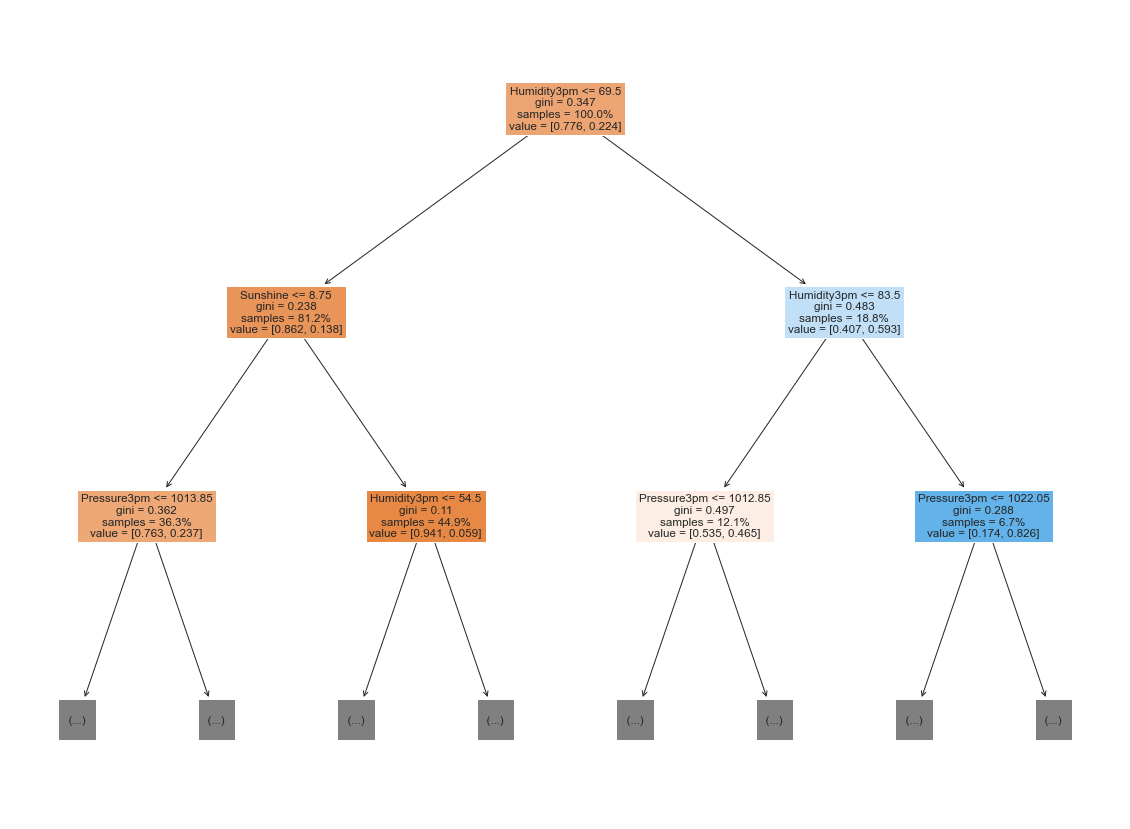

In [22]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(20,15))
plot_tree(dt_clf,feature_names = list(features),filled=True,proportion=True,max_depth=2)
plt.show()

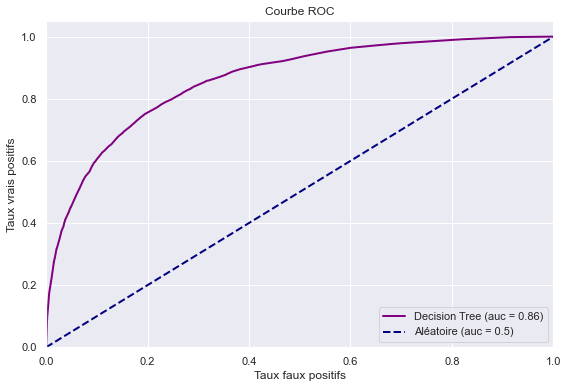

In [23]:
probs_dt = dt_clf.predict_proba(X_test)

fpr_dt, tpr_dt, seuils_dt = roc_curve(y_test,probs_dt[:,1],pos_label=1)
#fpr1, tpr1, seuils1 = det_curve(y_test,probs[:,1],pos_label=1)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(fpr_dt, tpr_dt, color='purple', lw=2, label='Decision Tree (auc = %0.2f)' % roc_auc_dt)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")

In [24]:
ac = AdaBoostClassifier(base_estimator=dt_clf,n_estimators=400)
ac.fit(X_train , y_train)
ac.score(X_test, y_test)

0.8308364271675038

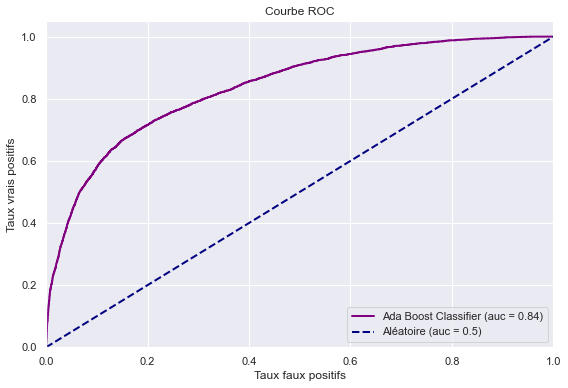

In [25]:
probs_ada = ac.predict_proba(X_test)

fpr_ada, tpr_ada, seuils_ada = roc_curve(y_test,probs_ada[:,1],pos_label=1)
roc_auc_ada = auc(fpr_ada, tpr_ada)

plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(fpr_ada, tpr_ada, color='purple', lw=2, label='Ada Boost Classifier (auc = %0.2f)' % roc_auc_ada)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")

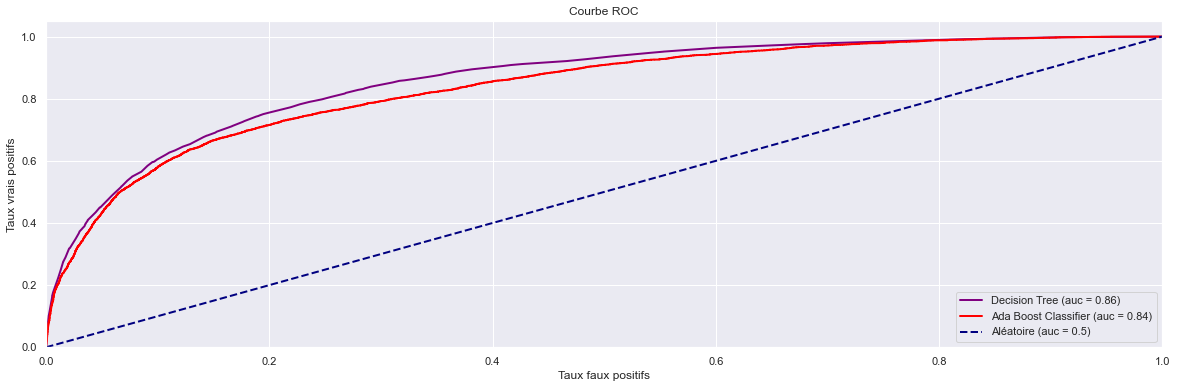

In [26]:
plt.figure(figsize=(20,6))
plt.plot(fpr_dt, tpr_dt, color='purple', lw=2, label='Decision Tree (auc = %0.2f)' % roc_auc_dt)
plt.plot(fpr_ada, tpr_ada, color='red', lw=2, label='Ada Boost Classifier (auc = %0.2f)' % roc_auc_ada)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")